In [41]:
from bs4 import BeautifulSoup
import requests
import time
from random import randint
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import pickle

## Scrape Data from Vivino

In [37]:
def scroll_bottom(scrolls, sleep_time):
    """
    Helper function for scrolling to the bottom of a webpage with Selenium.

        Parameters:
            scrolls (int): Number of times to scroll
            sleep_time (int): Seconds to wait before next scroll, accomodating for site-specified crawl delays
    
        Returns:
            Nothing
    """
    #initialize counter variable
    counter = 0
    
    while True:
        #increment count
        counter += 1 
        
        #stop if met or exceeded desired number of scrolls
        if counter >= scrolls:
            break
    
        # Get scroll height
        last_height = driver.execute_script("return document.body.scrollHeight")

        # Scroll down to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(10)

        # Calculate new scroll height and compare with last scroll height
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:

            # try again 
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            # Wait to load page
            time.sleep(sleep_time)

            # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")

            # check if the page height has remained the same
            if new_height == last_height:
                # if so done
                break
            # if not, move on to the next loop
            else:
                last_height = new_height
                continue

In [38]:
def get_wine_url(base_url = 'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1UMtNrLA1NTBQS660DQ1WSwYSLmoFQNn0NNuyxKLM1JLEHLX8JNuixJLMvPTi-OT80rwStXzblNTiZLXykuhYoFIwZQSlTCC0MYQyh1AmasW2yYkA-pkm0g%3D%3D&cart_item_source=nav-explore'):
    """
    Returns a list of url extensions to individual webpages for Vivino wines from a page of search results.

        Parameters:
            base_url (url): Link to webpage of search results
    
        Returns:
            wine_page_links (list): list of url extensions
    """
    #initliaze Selenium
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    driver.get(base_url)
    
    #scroll
    scroll_bottom(5, 10)
    
    #get links
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #wine_page_links = [link.get('href').strip() for link in soup.find_all('a', class_='anchor__anchor--2QZvA')]
    wine_page_links = []
    for link in soup.find_all('a', class_='anchor__anchor--2QZvA'):
        if "year=" in link.get('href').strip() and "cart_item_source" in link.get('href').strip():
            wine_page_links.append(link.get('href').strip())        
        else:
            pass
    
    return wine_page_links

In [ ]:
#save links
wine_page_links = get_wine_url()

In [39]:
#define helper functions to scrape specific data fields/wine attributes

def parse_ratings(soup):
    """
    Returns the rating of a Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            rating (str): Average rating of wine
    """
    rating = soup.find_all("div", class_=lambda value: value and value.startswith("vivinoRatingWide"))[0]
    return rating.text.split()[0]


def parse_winery(soup):
    """
    Returns the winery of a Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            winery (str): Name of winery
    """
    winery = soup.find(class_="winery")
    return winery.text.strip('\n')


def parse_wine_name(soup):
    """
    Returns the name of a Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            name (str): Name of wine
    """
    name = soup.find(class_="vintage")
    name = name.text.split()[:-1]
    return ' '.join(name)


def parse_wine_vintage(soup):
    """
    Returns the vintage year of a Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            vintage (str): Year the wine was made
    """
    vintage = soup.find(class_="vintage")
    return vintage.text.split()[-1]


def parse_wine_type(soup):
    """
    Returns the type (red, white, etc.) of a Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            type (str): Type of wine
    """
    type = soup.find(class_="wineLocationHeader__wineType--14nrC")
    return type.text


def parse_wine_region(soup):
    """
    Returns the region in which a Vivino wine was made from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            region (str): Region in which wine was made
    """
    region = soup.find(class_="anchor__anchor--3DOSm wineLocationHeader__region--1cbip")
    return region.text


def parse_wine_country(soup):
    """
    Returns the country in which a Vivino wine was made from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            region (str): Country in which wine was made
    """
    country = soup.find(class_="anchor__anchor--3DOSm wineLocationHeader__country--1RcW2")
    return country.text


def parse_number_reviews(soup):
    """
    Returns the number of reviews a Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            reviews (str): number of reviews
    """
    reviews = soup.find(class_="vivinoRatingWide__basedOn--s6y0t")
    return reviews.text[:-8]


def parse_avg_price(soup):
    """
    Returns the price of a bottle of Vivino wine from a Beautiful Soup object.

        Parameters:
            soup (bs4): Soup object containing source html for specific wine
    
        Returns:
            price (str): price of a wine
    """
    reviews = soup.find(class_="vivinoRatingWide__basedOn--s6y0t")
    return reviews.text[:-8]

In [42]:
def scrape_wine_info(sleep_time):
    """
    Takes a list of links and returns a dataframe with a list of attributes of the wines.

        Parameters:
            sleep_time (int): seconds to wait before opening next page, accomodating for site-specified crawl delays
    
        Returns:
            df (DataFrame): dataframe of wine attributes
    """
    avg_rating_list = []
    winery_list = []
    name_list = []
    vintage_list =[]
    type_list = []
    region_list = []
    country_list = []
    num_reviews_list = []
    avg_price_list = []

    base_url = 'https://www.vivino.com'
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)
    
    for page in wine_page_links:
        time.sleep(sleep_time)
        driver.get(base_url + page)
        soup = BeautifulSoup(driver.page_source, 'html.parser')      

        try:
            rating = parse_ratings(soup)
            avg_rating_list.append(rating)
        except:
            avg_rating_list.append('error')
            
        try:
            winery = parse_winery(soup)
            winery_list.append(winery)
        except:
            winery_list.append('error')
        
        try:
            name = parse_wine_name(soup)
            name_list.append(name)
        except:
            name_list.append('error')
            
        try:
            year = parse_wine_vintage(soup)
            vintage_list.append(year)
        except:
            vintage_list.append('error')
            
        try:
            wine_type = parse_wine_type(soup)
            type_list.append(wine_type)
        except:
            type_list.append('error') 
            
        try:
            region = parse_wine_region(soup)
            region_list.append(region)
        except:
            region_list.append('error')   
        
        try:
            country = parse_wine_country(soup)
            country_list.append(country)
        except:
            country_list.append('error')
        
        try:
            num_reviews = parse_number_reviews(soup)
            num_reviews_list.append(num_reviews)
        except:
            num_reviews_list.append('error')
            
        try:
            avg_price = parse_avg_price(soup)
            avg_price_list.append(avg_price)
        except:
            avg_price_list.append('error')
         
            
    features = ('Average Rating', 'Winery', 'Wine Name', 'Vintage',
                'Type', 'Region', 'Country', 'Number of Reviews',
               'Average Price')
    df = pd.DataFrame(list(zip(avg_rating_list, winery_list, name_list, vintage_list, type_list, region_list, 
                               country_list, num_reviews_list, avg_price_list)), columns =features) 
    
    return df

In [ ]:
#save dataframe
df = scrape_wine_info(10)

In [ ]:
#pickle
with open('wine_data_submission.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [43]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

sns.set_style("whitegrid", {"font.family": ["serif"]})
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [108]:
with open('wine_data_longer.pkl', 'rb') as picklefile: 
    wine_data = pickle.load(picklefile)

In [109]:
wine_data.head()

,Average Rating,Winery,Wine Name,Vintage,Type,Region,Country,Number of Reviews,Average Price
0,4.298098,Veuve Clicquot,Brut (Carte Jaune) Champagne,N.V.,Sparkling wine,Champagne,France,98098,49.99
1,4.187012,Moët & Chandon,Impérial Brut Champagne,N.V.,Sparkling wine,Champagne,France,87012,error
2,3.767924,Casal Garcia,Vinho Verde Branco,N.V.,White wine,Vinho Verde,Portugal,67924,error
3,4.352855,Farnese,Edizione Cinque Autoctoni,N.V.,Red wine,Abruzzo,Italy,52855,error
4,3.847411,Piccini,Memoro Rosso,N.V.,Red wine,Toscana,Italy,47411,10.99


## Data Cleaning

In [132]:
#remove rows with no average price
wine_data = wine_data[wine_data['Average Price'] != 'error']

#drop rows with no year
wine_data = wine_data[wine_data['Vintage'] != 'N.V.']

#drop rows after which rating scrape err'ed
wine_data = wine_data[:1295]

In [133]:
#convert strings to numerical
wine_data['Average Rating'] = wine_data['Average Rating'].astype(float)
wine_data['Number of Reviews'] = wine_data['Number of Reviews'].astype(int)
wine_data['Average Price'] = wine_data['Average Price'].astype(float)
wine_data['Vintage'] = wine_data['Vintage'].astype(int)

In [134]:
#convert vintage year to age
wine_data['Age'] = 2021 - wine_data['Vintage']

## EDA & Viz

In [135]:
wine_data.head()

,Average Rating,Winery,Wine Name,Vintage,Type,Region,Country,Number of Reviews,Average Price,Age
18,4.123169,Marqués de Riscal,Rioja Reserva,2014,Red wine,Rioja,Spain,23169,18.99,7
28,4.618701,Dom Pérignon,Brut Champagne,2006,Sparkling wine,Champagne,France,18701,249.99,15
30,3.618200,Casillero del Diablo,Cabernet Sauvignon (Reserva),2017,Red wine,Central Valley,Chile,18200,9.99,4
35,3.717321,Apothic,Red (Winemaker's Blend),2014,Red wine,California,United States,17321,13.98,7
45,4.316529,San Marzano,Cinquanta Collezione,2012,Red wine,Vino d'Italia,Italy,16529,23.21,9


In [136]:
#mean of target variable
wine_data['Average Rating'].mean()

3.9056903104247103

(array([  3.,  21.,  99., 238., 241., 208., 216., 159.,  80.,  30.]),
 array([2.93793 , 3.119221, 3.300512, 3.481803, 3.663094, 3.844385,
        4.025676, 4.206967, 4.388258, 4.569549, 4.75084 ]),
 <BarContainer object of 10 artists>)

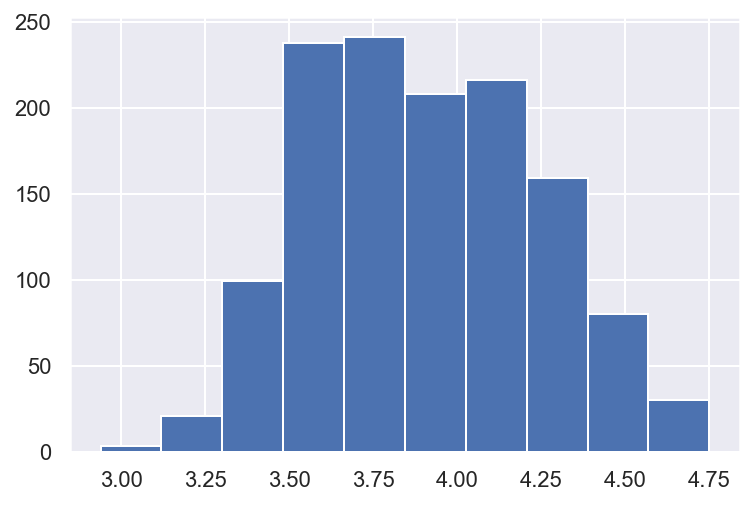

In [137]:
#distribution of target variable
hist(wine_data['Average Rating'])

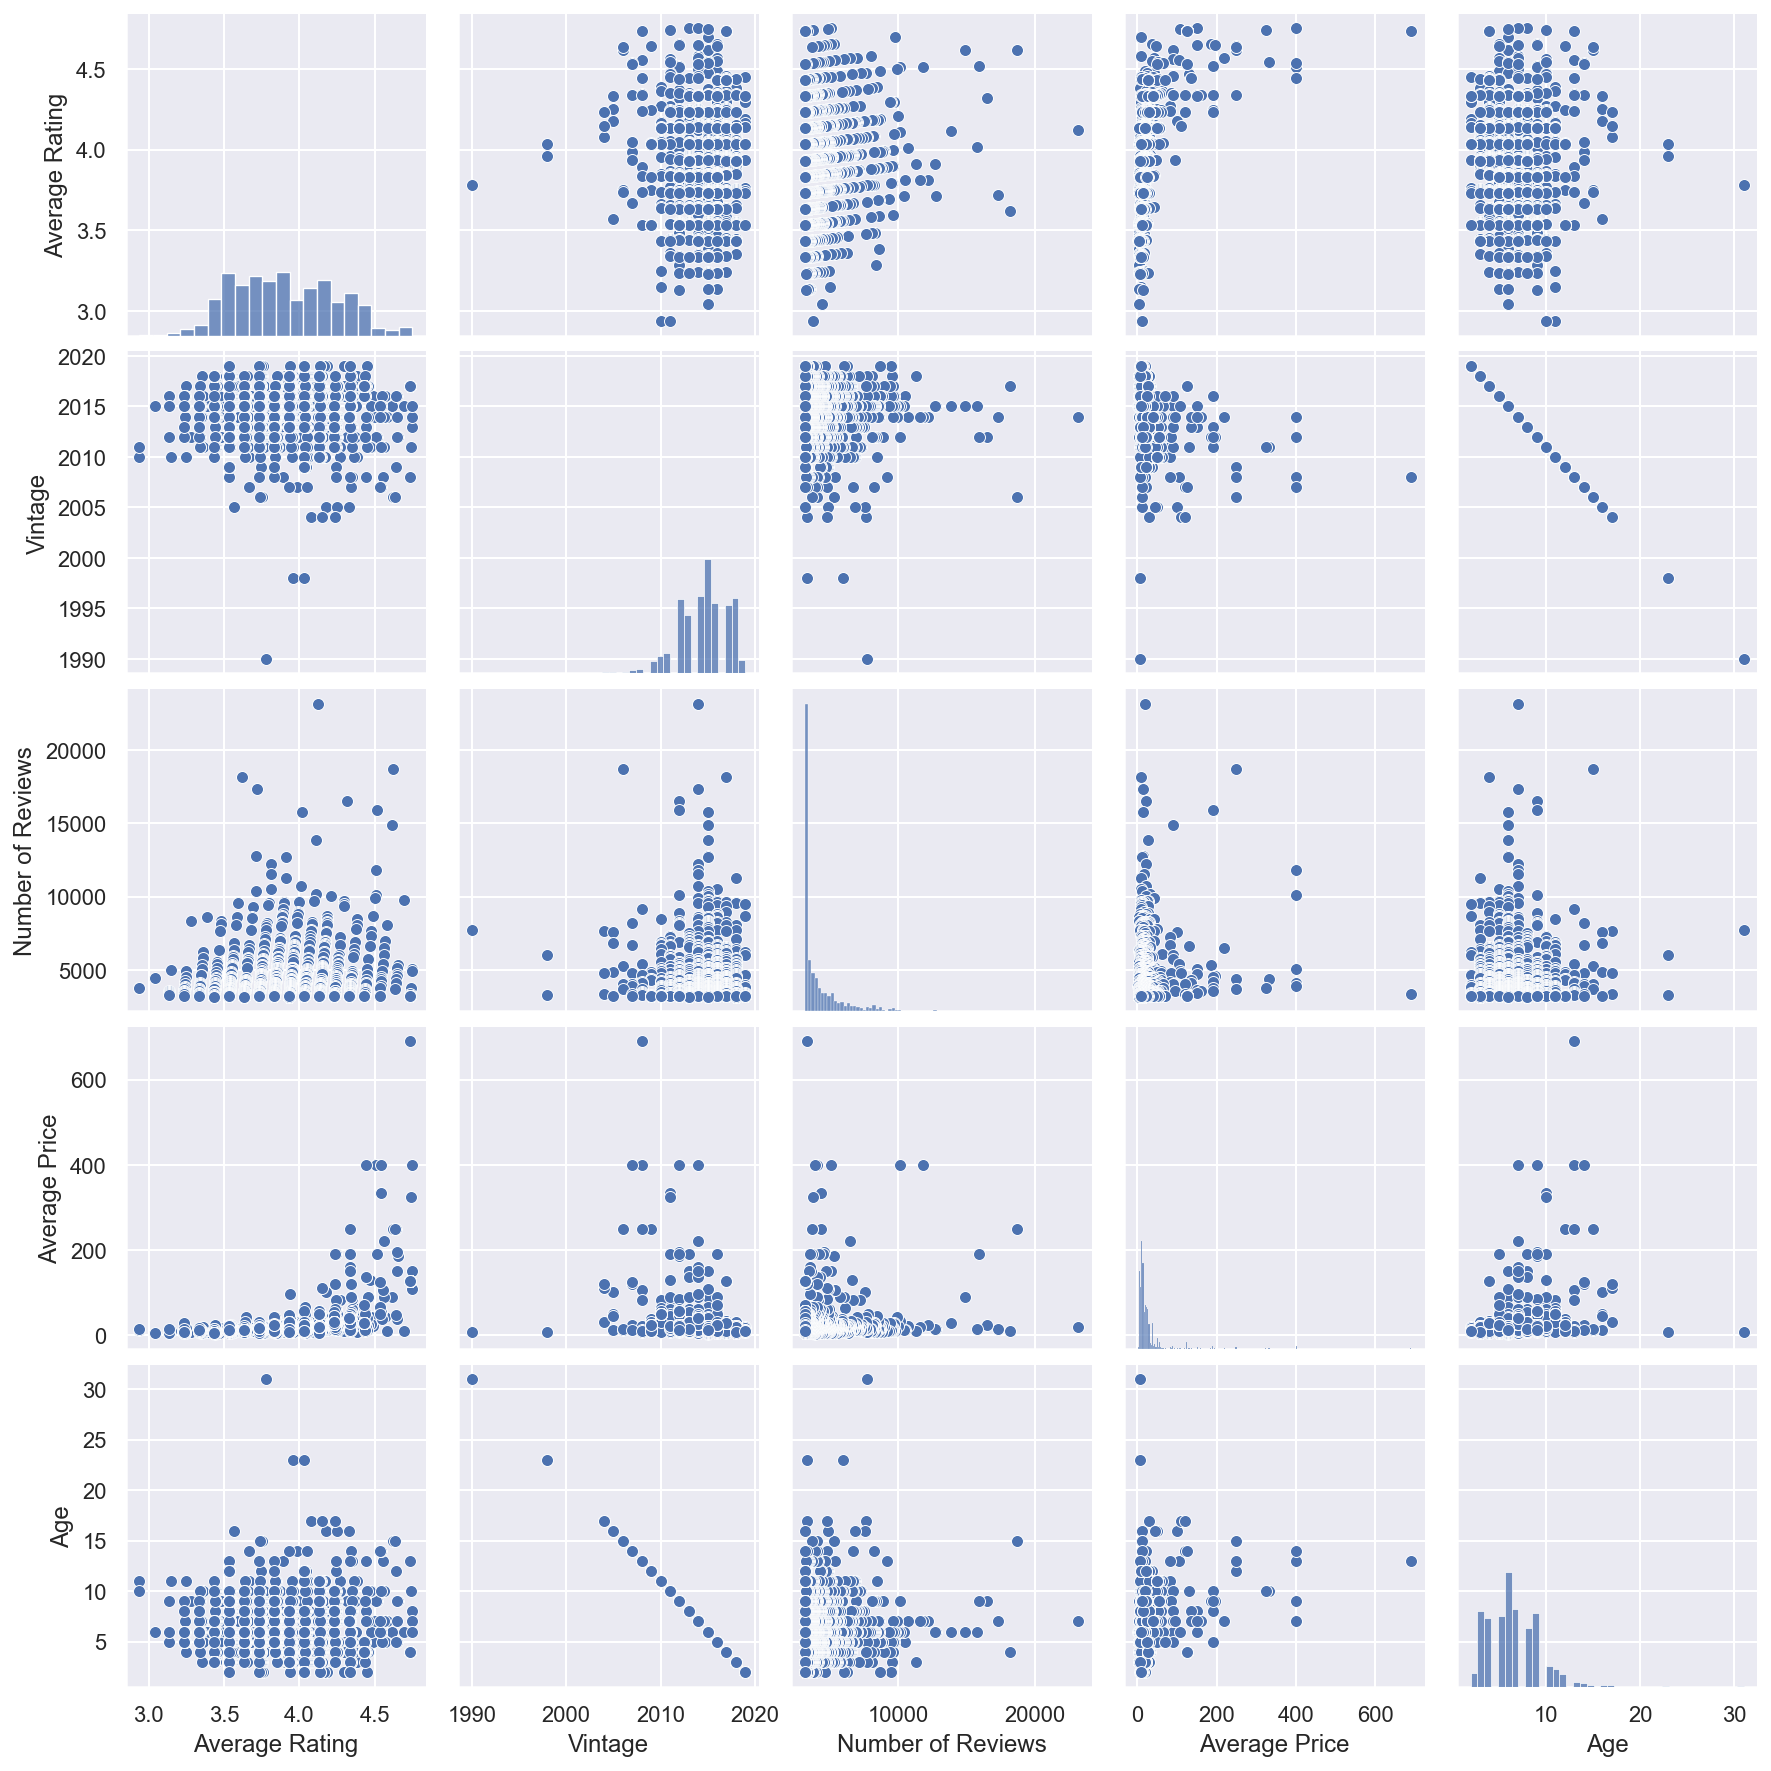

In [138]:
#explore relationships with pair plot
sns.pairplot(wine_data)

In [139]:
#explore key categorical variables

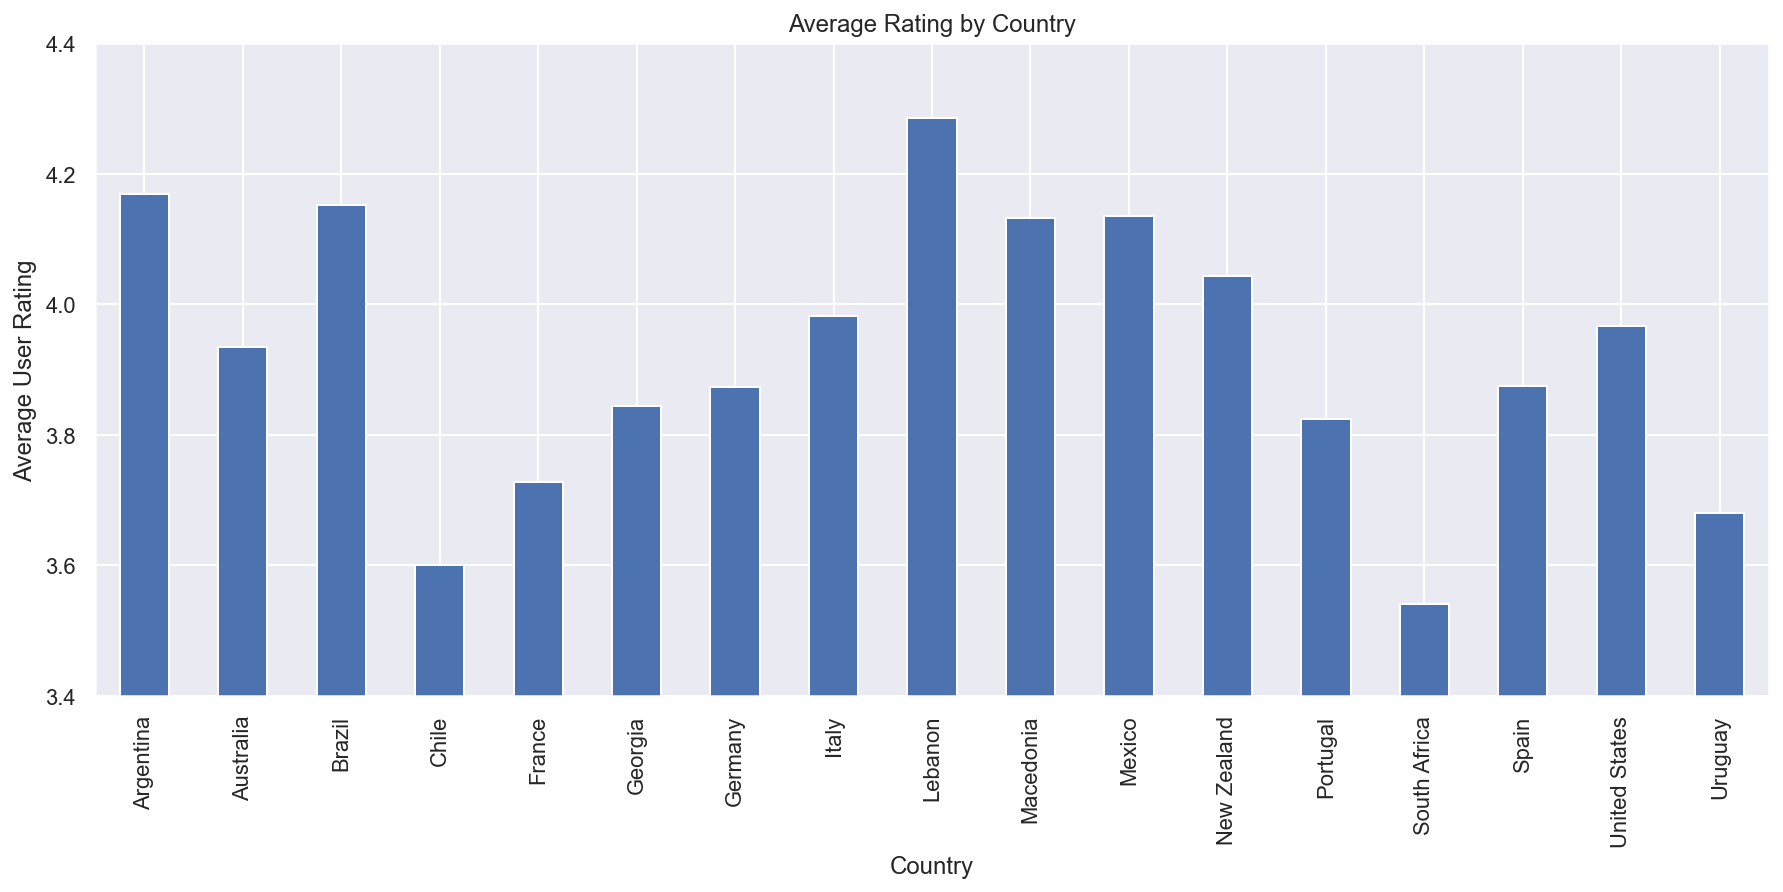

In [140]:
#barchart for average rating by country
wine_ratings_by_country = wine_data.groupby('Country')['Average Rating'].mean()
ax = wine_ratings_by_country.plot.bar(x = 'country', y='Average User Rating', figsize = (15,6), title='Average Rating by Country')
ax.set_ylabel("Average User Rating")
ax.set_ylim(3.4,4.4)
ax.set_title=('Average Rating by Country')

(3.5, 4.5)

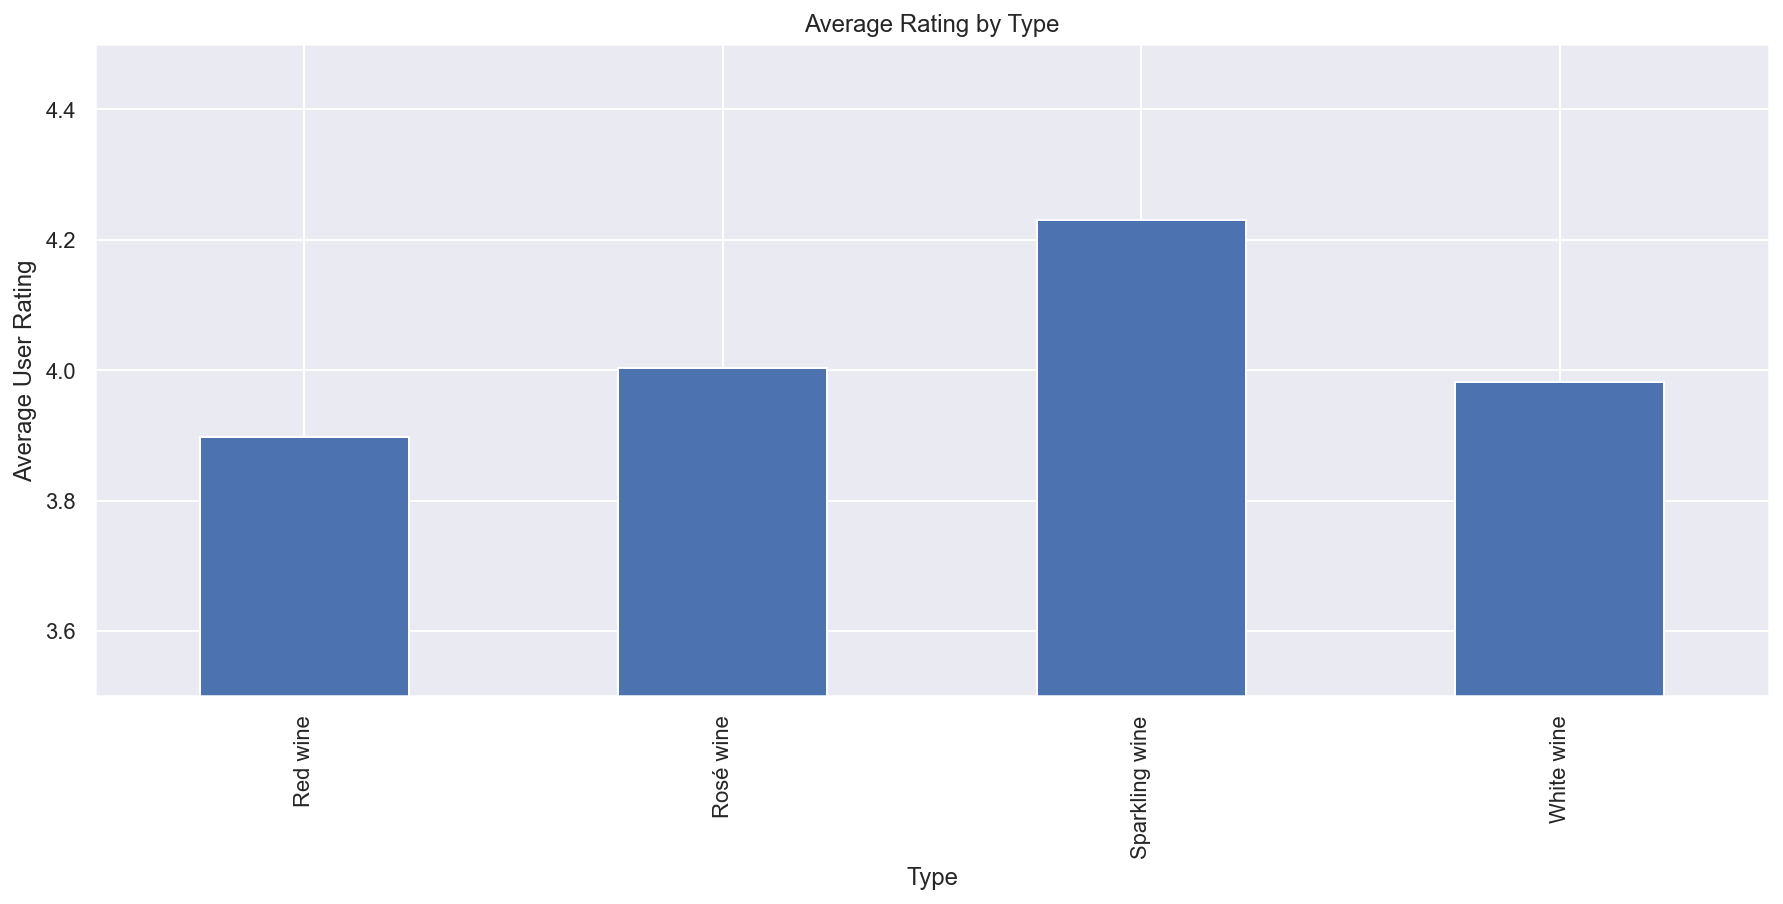

In [141]:
#type bar chart
wine_ratings_by_type = wine_data.groupby('Type')['Average Rating'].mean()
ax = wine_ratings_by_type.plot.bar(x = 'Type', y='Average User Rating', figsize = (15,6), title='Average Rating by Type')
ax.set_ylabel("Average User Rating")
ax.set_ylim(3.5,4.5)

## Begin Model Building

In [142]:
#split the data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine_data[['Age', 'Type', 'Country', 'Number of Reviews',
                                                                 'Average Price']], wine_data['Average Rating'], 
                                                    test_size = .25, random_state=100101)

In [84]:
#try some simple single variable regressions on key feature variables

In [143]:
#wine vintage
X = X_train[['Age']]
y = y_train

lr = LinearRegression()
lr.fit(X, y)

y_predicted = lr.predict(X)

In [144]:
score = lr.score(X, y)
score

0.0002541347881700462

In [145]:
#set graph style
sns.set_theme(color_codes=True)

Text(0.5, 1.0, 'Age vs. Rating')

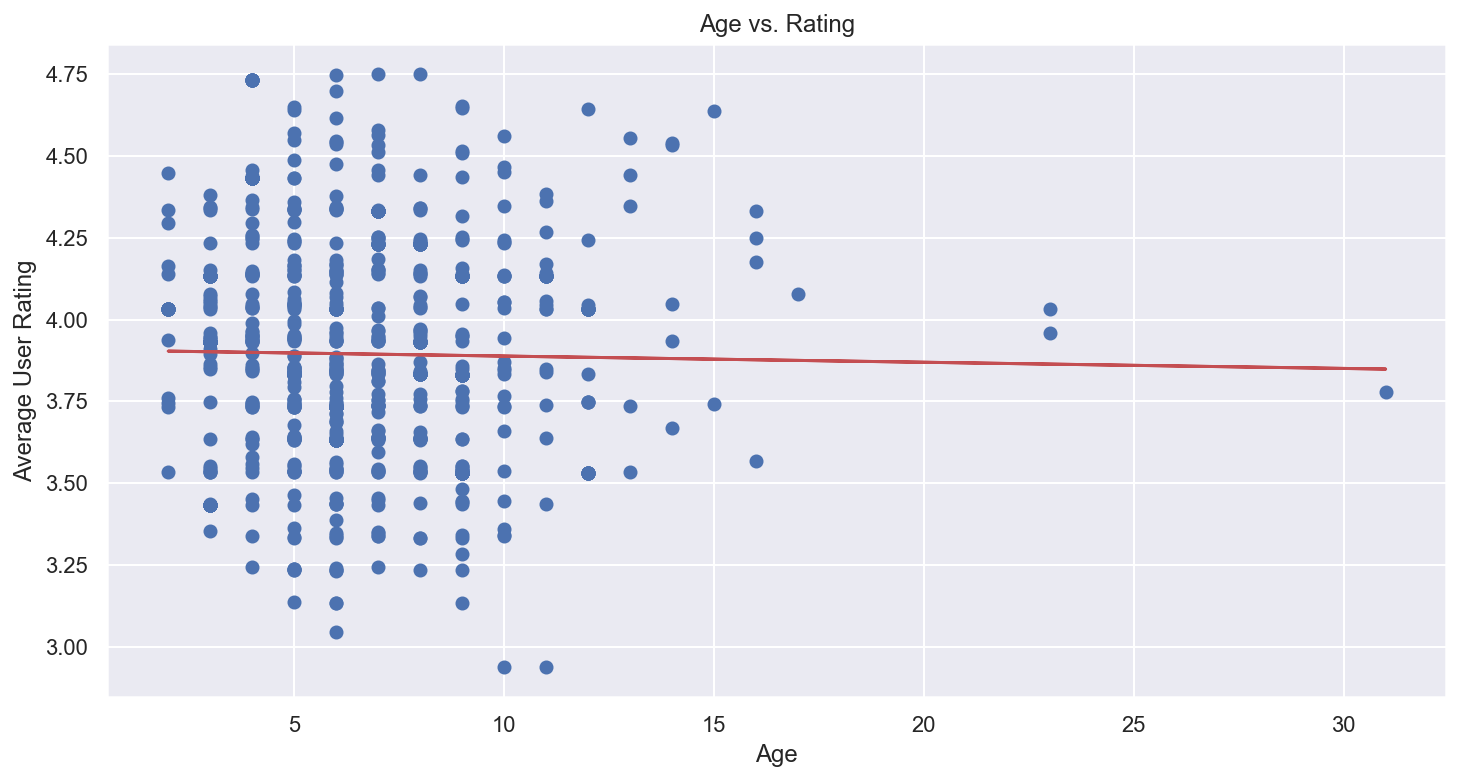

In [146]:
#plot 
plt.figure(figsize=(12, 6))
plt.plot(X_train[['Age']], y_train, 'o')
plt.plot(X_train[['Age']], y_predicted, 'r')
plt.xlabel('Age')
plt.ylabel('Average User Rating')
plt.title('Age vs. Rating')

In [147]:
#bottle price
X = X_train[['Average Price']]
y = y_train

lr = LinearRegression()
lr.fit(X, y)

y_predicted = lr.predict(X)

In [148]:
score = lr.score(X, y)
score

0.2453820880302644

Text(0.5, 1.0, 'Price vs. Rating')

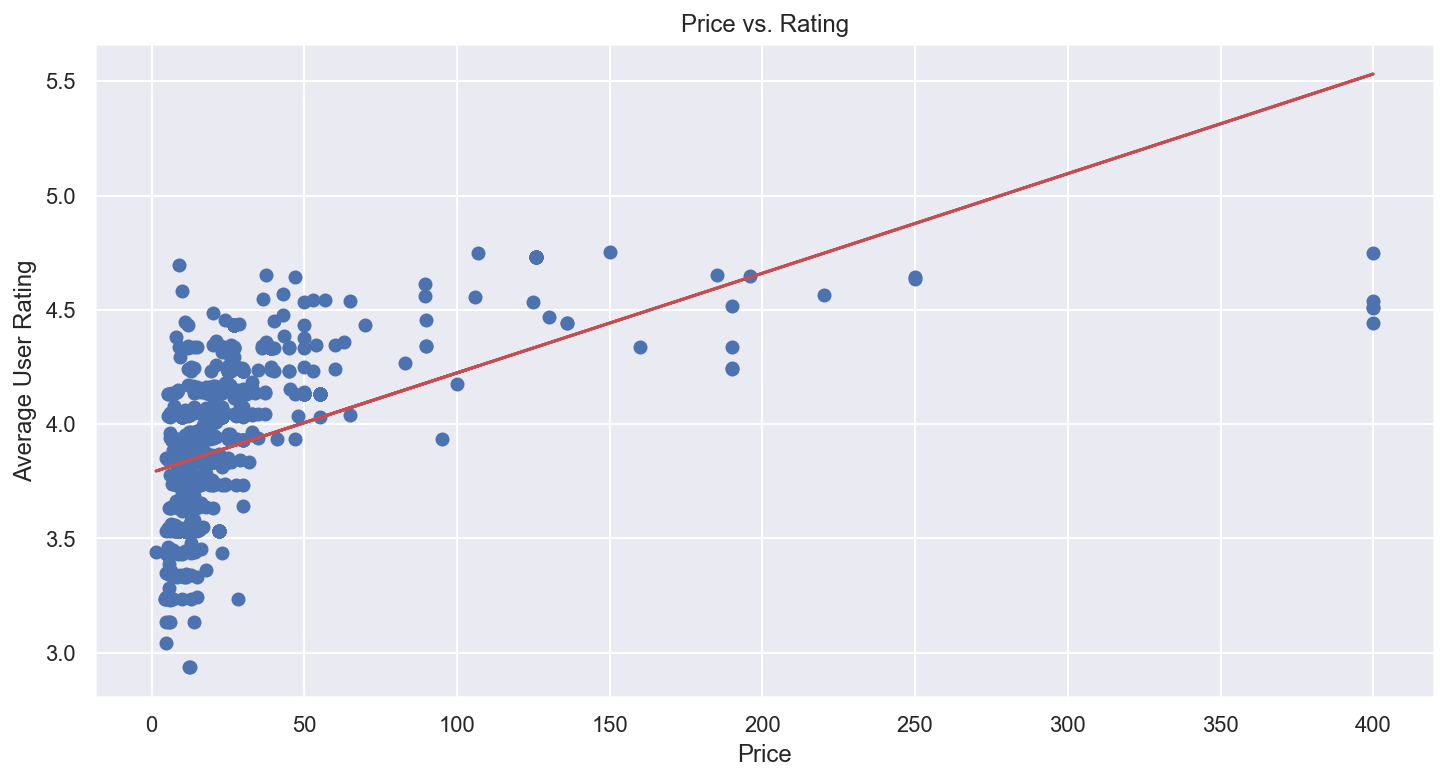

In [149]:
#plot 
plt.figure(figsize=(12, 6))
plt.plot(X_train[['Average Price']], y_train, 'o')
plt.plot(X_train[['Average Price']], y_predicted, 'r')
plt.xlabel('Price')
plt.ylabel('Average User Rating')
plt.title('Price vs. Rating')

In [154]:
#transform categorical variables into dummmies
X_train_dummies = pd.get_dummies(data=X_train, columns=['Country', 'Type'], drop_first = True)

#combine back into dataframe
combine_list = [X_train, X_train_dummies]
X_train = pd.concat(combine_list, axis=1)

In [157]:
X_train

,Age,Type,Country,Number of Reviews,Average Price,Age,Number of Reviews,Average Price,Country_Australia,Country_Brazil,...,Country_Mexico,Country_New Zealand,Country_Portugal,Country_South Africa,Country_Spain,Country_United States,Country_Uruguay,Type_Rosé wine,Type_Sparkling wine,Type_White wine
1521,6,Red wine,Chile,3677,5.59,6,3677,5.59,0,0,...,0,0,0,0,0,0,0,0,0,0
794,9,Red wine,Spain,5090,32.99,9,5090,32.99,0,0,...,0,0,0,0,1,0,0,0,0,0
2997,3,Red wine,Chile,3193,4.99,3,3193,4.99,0,0,...,0,0,0,0,0,0,0,0,0,0
1677,8,Red wine,Chile,3521,5.84,8,3521,5.84,0,0,...,0,0,0,0,0,0,0,0,0,0
1067,6,Red wine,Chile,4441,4.66,6,4441,4.66,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1721,5,Red wine,Spain,3483,19.99,5,3483,19.99,0,0,...,0,0,0,0,1,0,0,0,0,0
2590,6,Red wine,Portugal,3198,15.32,6,3198,15.32,0,0,...,0,0,1,0,0,0,0,0,0,0
2647,3,Red wine,Chile,3193,4.99,3,3193,4.99,0,0,...,0,0,0,0,0,0,0,0,0,0
274,4,Red wine,Argentina,8053,13.99,4,8053,13.99,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
#attempting first real model - linear regression with all features

X = X_train[['Age', 'Average Price', 'Number of Reviews', 'Type_Rosé wine', 
                            'Type_Sparkling wine', 'Type_White wine', 'Country_Australia', 'Country_Brazil', 
                            'Country_Chile', 'Country_France', 'Country_Georgia', 'Country_Germany', 'Country_Italy', 
                            'Country_Lebanon', 'Country_Macedonia', 'Country_Mexico', 'Country_New Zealand', 'Country_Portugal',
                            'Country_South Africa', 'Country_Spain', 'Country_United States', 'Country_Uruguay']]
y = y_train

lr = LinearRegression()
lr.fit(X, y)

y_predicted = lr.predict(X)

KeyError: "['Country_Lebanon'] not in index"